In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from trigger import *
from time import time

### How to calculate the SNR?
It's defined as the ratio between the amplitude of the signal and the standard deviation of the noise

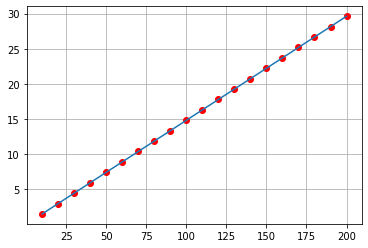

The linear fit is 0.148140 * x + 0.000032


In [22]:
A = []
amplitude = np.linspace(10, 200, 20)
for amp in amplitude:
    signal = gen_signal(baseline=-10, amplitude=amp, noise_lev=0, plot=False, pulse_start=np.random.uniform(199.5,200.5))
    A.append(-signal.min()-10)
plt.plot(amplitude, A, 'ro')
m, q = np.polyfit(amplitude, A, 1)
x = np.linspace(10,200,1000)
plt.plot(x, m * x + q)
plt.grid()
plt.show()
print('The linear fit is %f * x + %f' %(m, q))

### How does savgol filter work?

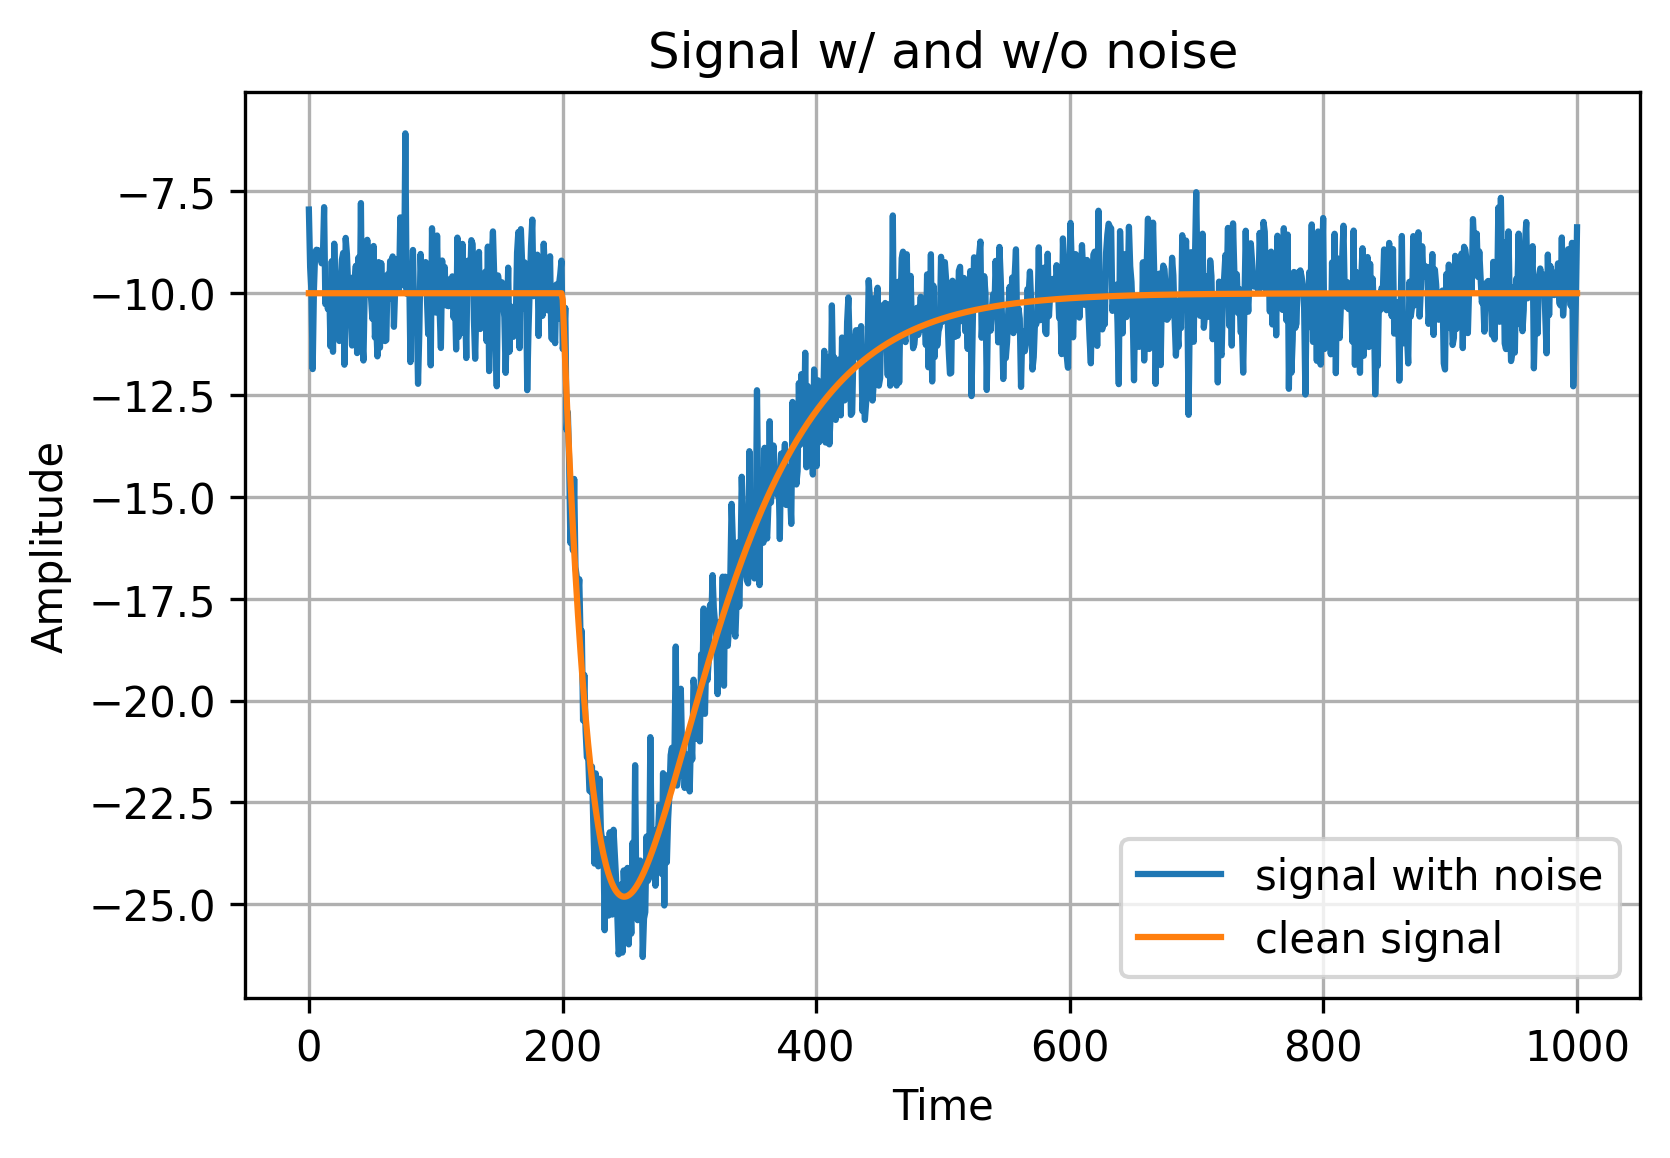

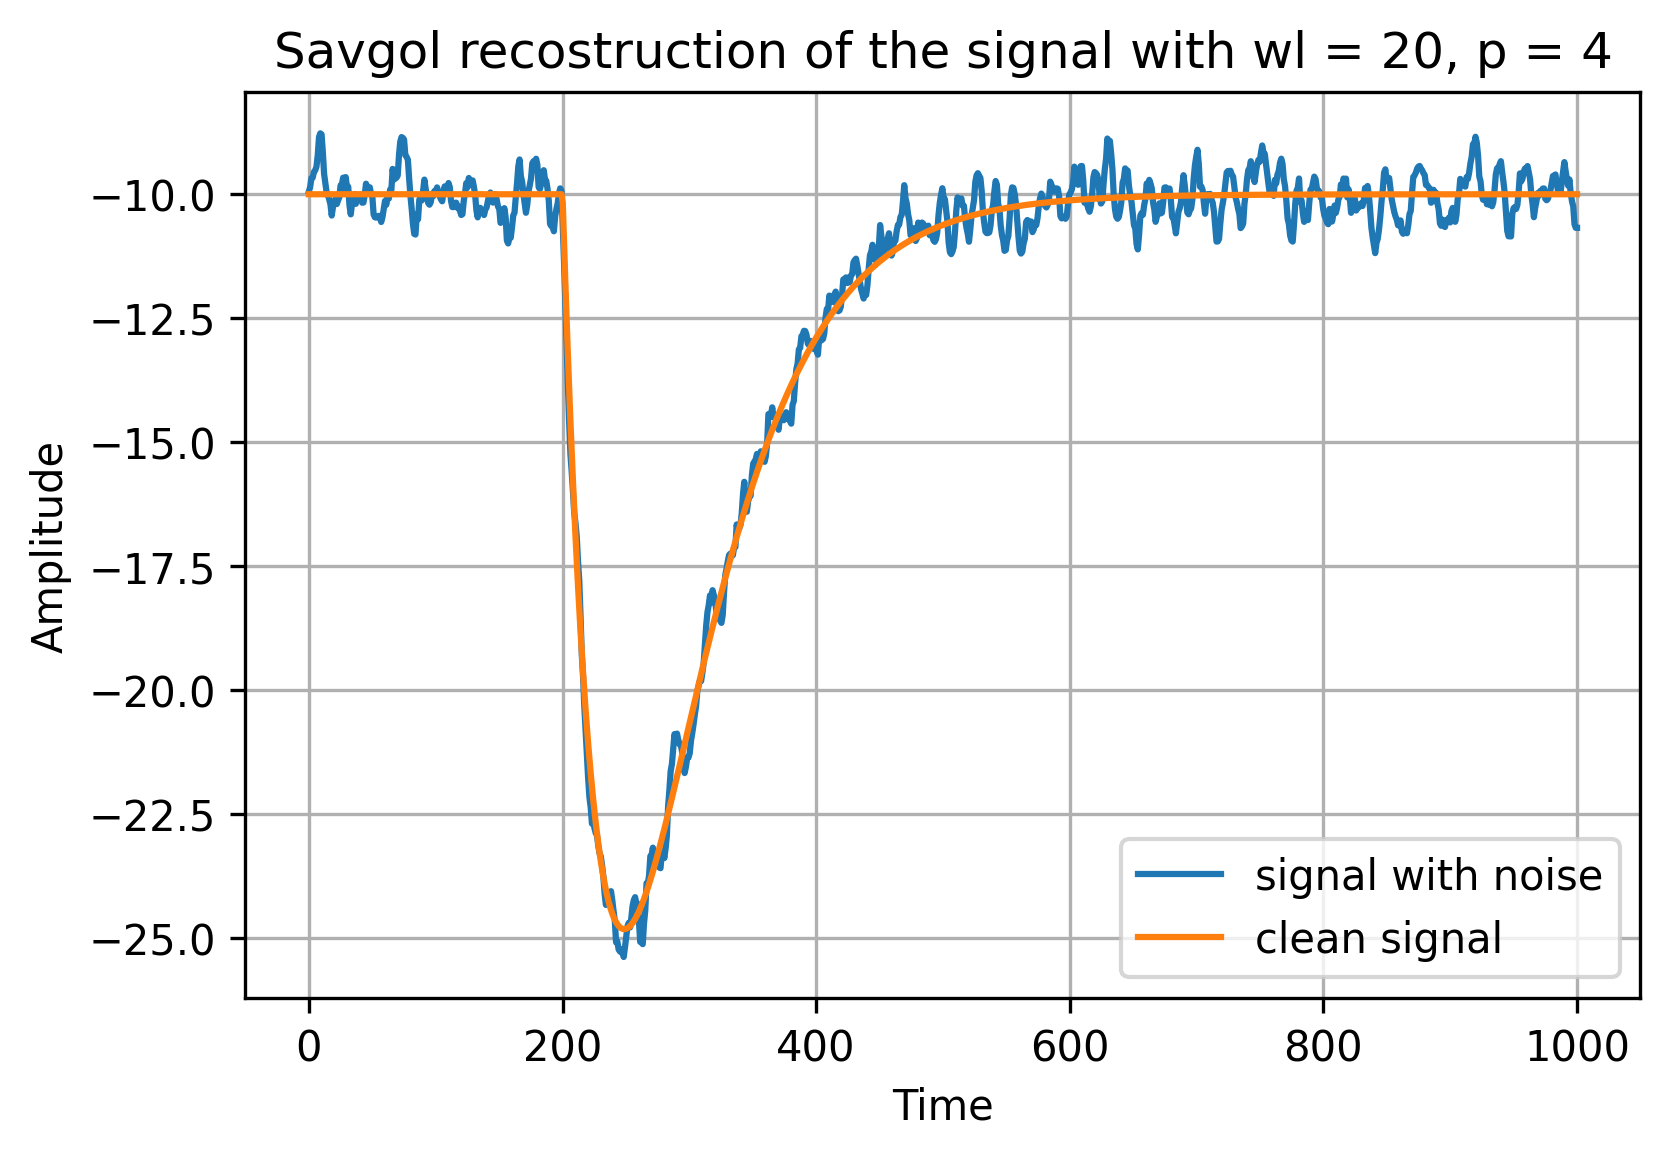

In [88]:
p = 4
wl = 20
amp = 100

time = np.linspace(0, 1000, 1000)
clean_signal = gen_signal(baseline    = -10, 
                          amplitude   = amp, 
                          noise_lev   = 0, 
                          plot        = False, 
                          pulse_start = 200)
signal       = gen_signal(baseline    = -10, 
                          amplitude   = amp, 
                          noise_lev   = 1, 
                          plot        = False, 
                          pulse_start = 200)
multiple_plots(time, 
               signal, 'signal with noise', 
               clean_signal, 'clean signal',  
               title   = 'Signal w/ and w/o noise', 
               x_label = 'Time', 
               y_label = 'Amplitude', 
               save    = False)

#change deriv to see the reco of the derivative
clean_filtered_signal = savgol_filter(clean_signal, 
                                      window_length = 7, 
                                      polyorder     = 6, 
                                      deriv         = 0, 
                                      delta         = 1, 
                                      mode          = 'mirror')
filtered_signal       = savgol_filter(signal, 
                                      window_length = int(wl), 
                                      polyorder     = int(p), 
                                      deriv         = 0, 
                                      delta         = 1, 
                                      mode          = 'mirror')

multiple_plots(time, 
               filtered_signal, 'signal with noise', 
               clean_filtered_signal, 'clean signal', 
               title   = 'Savgol recostruction of the noisy signal with wl = %d, p = %d' %(wl, p), 
               x_label = 'Time', 
               y_label = 'Amplitude', 
               save = False)

### Minimum using a parabola

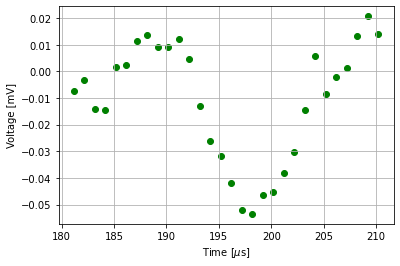

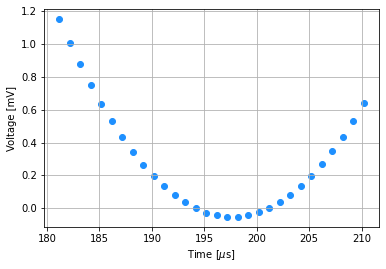

Minimum found at position [197.68463305703483]


In [94]:
poly = 6
wl = 50
signals=[]
time = np.linspace(0, 1000, 1000)
signals.append(gen_signal(baseline=-10, amplitude=50, noise_lev=1, plot=False, pulse_start=np.random.uniform(199.5,200.5)))

min = derivative_trigger_matrix2(signals, window_ma=21, wl = 20, poly=3, mv = 'convolve', vertex = True, plot=True)
print('Minimum found at position ' + str(min))

### Study on savgol parameters

In [22]:
def savgol_rss(sample, derivative_func):
    rss = []
    for k in range(len(signal)):
        rss.append((sample[k] - derivative_func[k])**2)
        
    return sum(rss)

In [101]:
amplitude = np.linspace(10,100,10)
win_len = np.linspace(20,60,5)

In [ ]:
max = 0
file = open("data4Dplot.txt","a")
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')
time = np.linspace(0, 1000, 1000)
for wl in win_len:
    for p in range(3, 10, 2):
        for amp in amplitude:
            rss = 0
            snr = 0.148140 * amp + 0.000032
            clean_signal = gen_signal(baseline=-10, amplitude=amp, noise_lev=0, plot=False, pulse_start=200)
            clean_filtered_signal = savgol_filter(clean_signal, window_length = 7, polyorder = 6, deriv = 0, delta=1, mode='mirror')
            for i in range(1000):
                signal = gen_signal(baseline=-10, amplitude=amp, noise_lev=1, plot=False, pulse_start=200)
                filtered_signal = savgol_filter(signal, window_length = int(wl), polyorder = int(p), deriv = 0, delta=1, mode='mirror')
                rss = savgol_rss(clean_filtered_signal, filtered_signal) if savgol_rss(clean_filtered_signal, filtered_signal) > rss else rss

            file.write(str(wl) +' ' +str(p)+' '+ str(amp) +' '+ str(rss) + '\n')
            img = ax.scatter(wl, p, snr, c=rss, cmap=plt.jet())
            #print('wl = %f, p = %f, amp = %f, rss = %f' %(wl, p, amp, rss))
            #print('%f %f %f %f' %(wl, p, snr, rss))
        print('p %d done' %p)
    print('wl %d done' %wl)
fig.colorbar(img)

ax.set_xlabel('win_len')   
ax.set_ylabel('poly_order')   
ax.set_zlabel('SNR') 
plt.show()
file.close() 

In [105]:
data = np.loadtxt('data4Dplot.txt')
data2 = np.transpose(data)
data3 = []
#only to show less data or on a narrower range
for i in range(len(data)):
    if (data[i][3] < 200):
        data3.append(data[i])
data3 = np.transpose(data3)

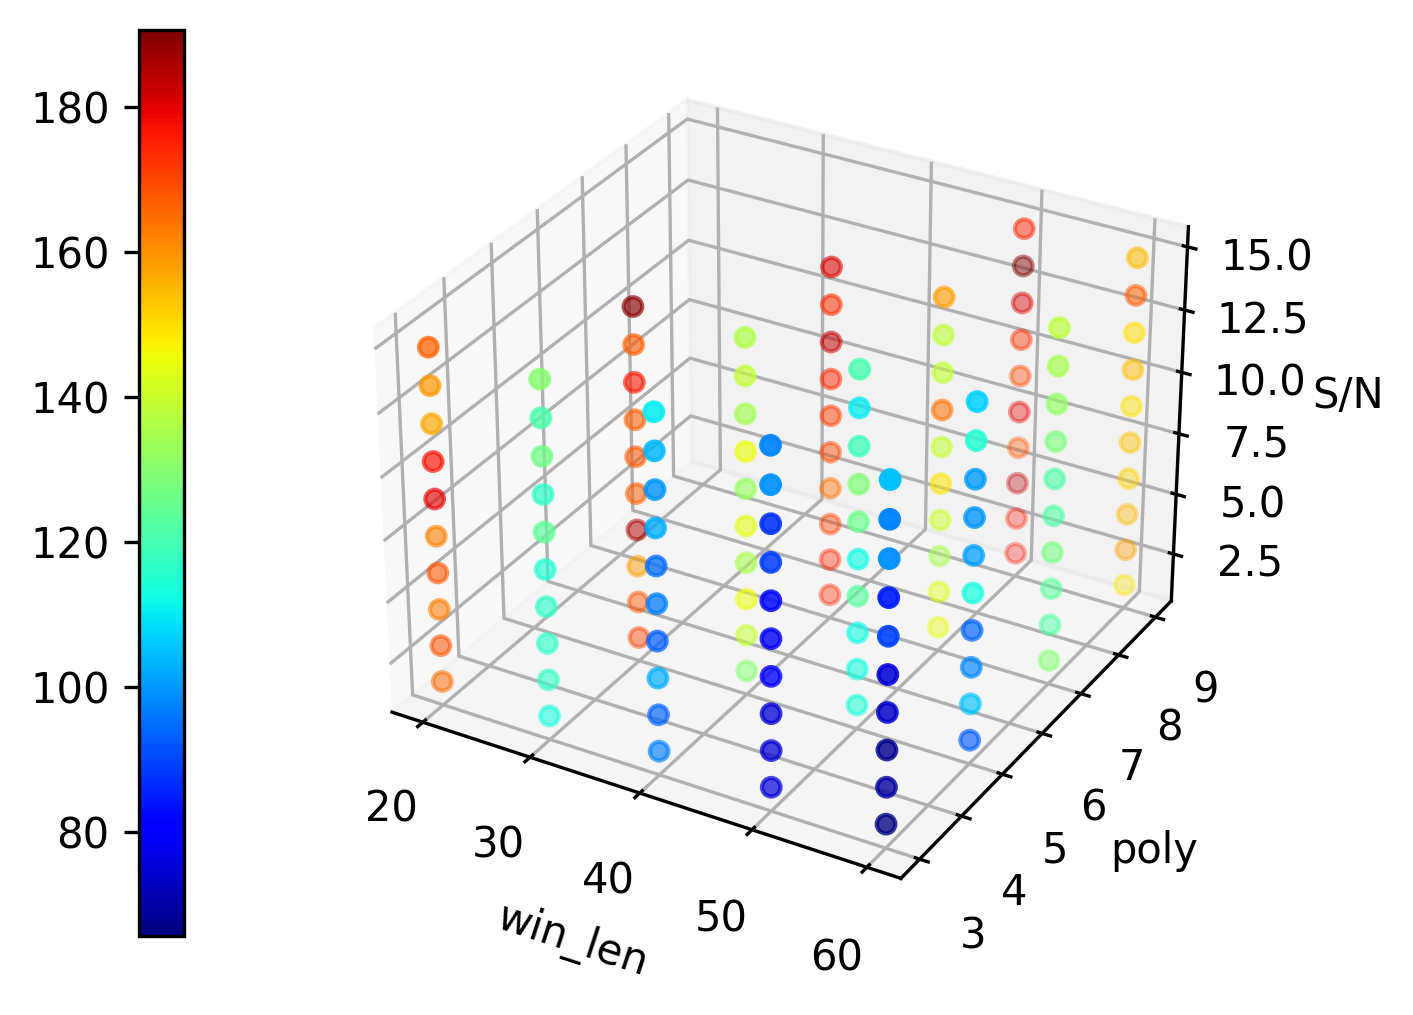

In [111]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')
x = data3[0] 
y = data3[1]
z = 0.148140 * data3[2] + 0.000032
colors = data3[3]
img = ax.scatter(x, y, z, c=colors, cmap=plt.jet())
fig.colorbar(img, location='left')
ax.set_xlabel('win_len')   
ax.set_ylabel('poly')   
ax.set_zlabel('S/N') 
plt.show()

### From this link, difficult to gain info from it
https://nirpyresearch.com/choosing-optimal-parameters-savitzky-golay-smoothing-filter/

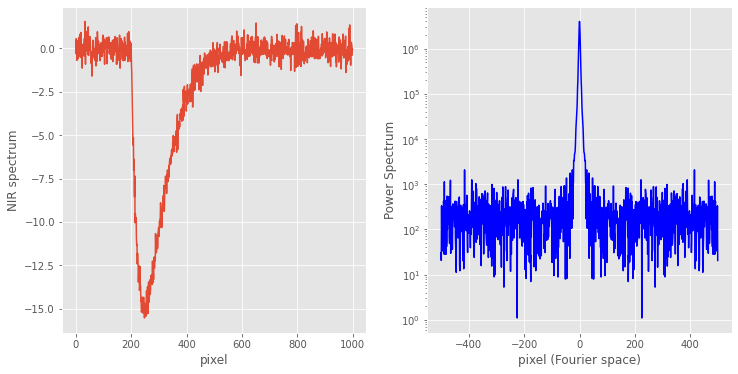

In [143]:
from scipy.signal import savgol_filter, general_gaussian
 
X = gen_signal(baseline=0, amplitude=100, noise_lev=.5, plot=False, pulse_start=np.random.uniform(199.5,200.5))
wl = np.linspace(3,30,10)
 
# Calculate the power spectrum 
ps = np.abs(np.fft.fftshift(np.fft.fft(X)))**2
 
# Define pixel in original signal and Fourier Transform
pix = np.arange(X.shape[0])
fpix = np.arange(ps.shape[0]) - ps.shape[0]//2
 
with plt.style.context(('ggplot')):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].plot(pix, X)
    axes[0].set_xlabel('pixel')
    axes[0].set_ylabel('NIR spectrum')
    
    axes[1].semilogy(fpix, ps, 'b')
    axes[1].set_xlabel('pixel (Fourier space)')
    axes[1].set_ylabel('Power Spectrum')

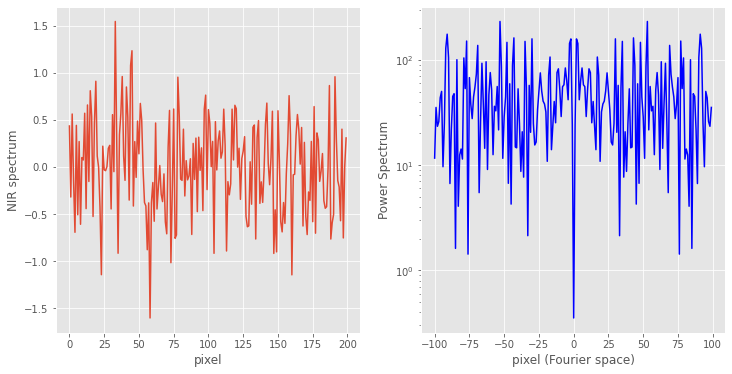

In [158]:
begin = 0
end = 200
# Calculate the power spectrum 
ps = np.abs(np.fft.fftshift(np.fft.fft(X[begin:end])))**2
 
# Define pixel in original signal and Fourier Transform
pix = np.arange(X[begin:end].shape[0])
fpix = np.arange(ps.shape[0]) - ps.shape[0]//2
 
with plt.style.context(('ggplot')):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].plot(pix, X[begin:end])
    axes[0].set_xlabel('pixel')
    axes[0].set_ylabel('NIR spectrum')
    
    axes[1].semilogy(fpix, ps, 'b')
    axes[1].set_xlabel('pixel (Fourier space)')
    axes[1].set_ylabel('Power Spectrum')

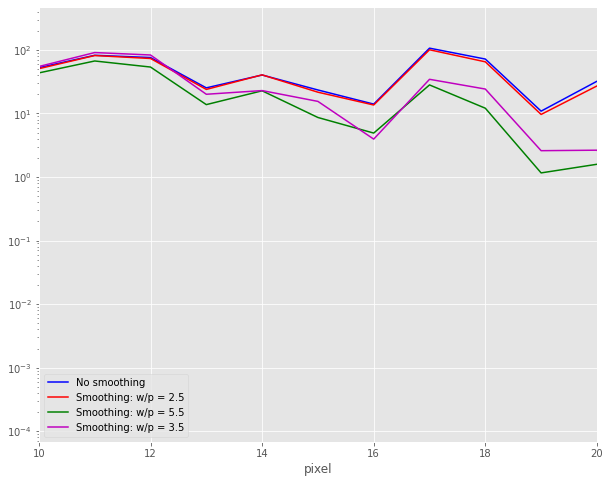

In [165]:
# Set some reasonable parameters to start with
w = 7
p = 2
# Calculate three different smoothed spectra
X_smooth_1 = savgol_filter(X, w, polyorder = p, deriv=0)
X_smooth_2 = savgol_filter(X, 2*w+1, polyorder = p, deriv=0)
X_smooth_3 = savgol_filter(X, 4*w+1, polyorder = 3*p, deriv=0)
 
# Calculate the power spectra in a featureless region
ps = np.abs(np.fft.fftshift(np.fft.fft(X[begin:end])))**2
ps_1 = np.abs(np.fft.fftshift(np.fft.fft(X_smooth_1[begin:end])))**2
ps_2 = np.abs(np.fft.fftshift(np.fft.fft(X_smooth_2[begin:end])))**2
ps_3 = np.abs(np.fft.fftshift(np.fft.fft(X_smooth_3[begin:end])))**2
 
# Define pixel in Fourier space
fpix = np.arange(ps.shape[0]) - ps.shape[0]//2
 
plt.figure(figsize=(10,8))
with plt.style.context(('ggplot')):
    plt.semilogy(fpix, ps, 'b', label = 'No smoothing')
    plt.semilogy(fpix, ps_1, 'r', label = 'Smoothing: w/p = 2.5')
    plt.semilogy(fpix, ps_2, 'g', label = 'Smoothing: w/p = 5.5')
    plt.semilogy(fpix, ps_3, 'm', label = 'Smoothing: w/p = 3.5')
    plt.legend()
    plt.xlabel('pixel')
    plt.xlim(10,20)